In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import timeit
import signal

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable
import torchvision.transforms as T

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'hot'

In [5]:
from simulation import Scene

%load_ext autoreload
%autoreload 2

In [6]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [7]:
ctx = cl.create_some_context()

In [8]:
def get_image(scene):
    cbuf, vbuf = scene.buffers["color"], scene.buffers["velocity"]
    cbuf.load(scene.queue)
    vbuf.load(scene.queue)
    cimg, vimg = cbuf.host[:,:,1:2].copy(), 0.01*vbuf.host.copy()
    img = np.concatenate((cimg, vimg), axis=2)
    img = img.transpose((2,0,1))
    return img

In [9]:
def convert_image(image):
    image = image[np.array([1,0,2])].transpose((1,2,0))
    image = np.minimum(np.maximum(image,0),1)
    return (255*image).astype(np.uint8)

In [10]:
def plot_images(data):
    if len(data.shape) == 3:
        plt.imshow(convert_image(data))
        plt.axis('off')
    elif len(data.shape) == 4:
        for i, img in enumerate(data):
            plt.subplot(1, len(data), i+1)
            plt.imshow(convert_image(img))
            plt.axis('off')
    elif len(data.shape) == 5:
        for j, seq in enumerate(data):
            for i, img in enumerate(seq):
                plt.subplot(len(seq), len(data), i*len(data)+j+1)
                plt.imshow(convert_image(img))
                plt.axis('off')
    plt.show()

In [11]:
def random_draw(scene, n):
    n = np.random.randint(0, n)
    for i in range(n):
        x = np.random.uniform(0, scene.size[0])
        y = np.random.uniform(0, scene.size[1])
        r = 0.1*min(*scene.size)
        r = np.random.uniform(0.05*r, r)
        v = 100.0
        vx = np.random.uniform(-v, v)
        vy = np.random.uniform(-v, v)
        #c = np.random.randint(1, 8)
        #col = ((c>>0)&1,(c>>1)&1,(c>>2)&1)
        col = (0,1,0)
        scene.draw("circle", col, (vx, vy), (x, y), r)

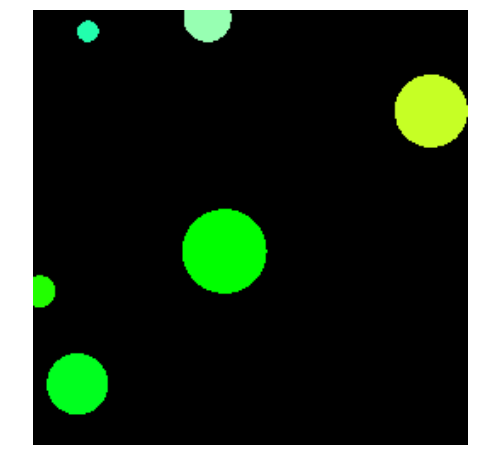

In [12]:
scene = Scene(
    ctx,
    (256, 256),
    params={
        "time_step": 0.01,
        "grid_size": 0.001,
        "pressure_steps": 64,
        "viscosity": 1e-6,
})
random_draw(scene, 50)
plot_images(get_image(scene))

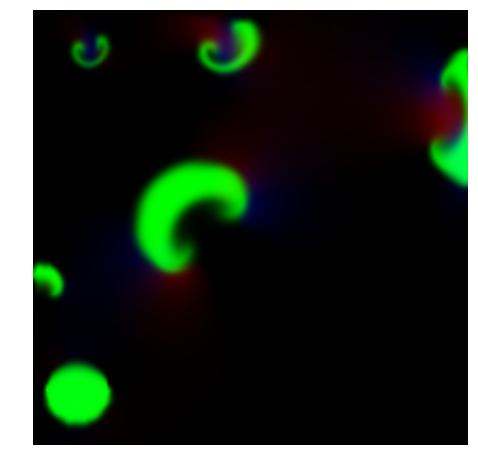

In [13]:
for i in range(100):
    scene.step()
plot_images(get_image(scene))

In [14]:
def generate_sequence(imgsize, seqlen, stride):
    scene = Scene(
        ctx,
        imgsize,
        params={
            "time_step": 0.01,
            "grid_size": 0.001,
            "pressure_steps": 64,
            "viscosity": 1e-6,
    })
    random_draw(scene, 100)
    
    seq = [get_image(scene)]
    for i in range(seqlen-1):
        for j in range(stride):
            scene.step()
        img = get_image(scene)
        seq.append(img)
        
    seq = np.stack(seq)
    
    return seq

(10, 3, 64, 64)


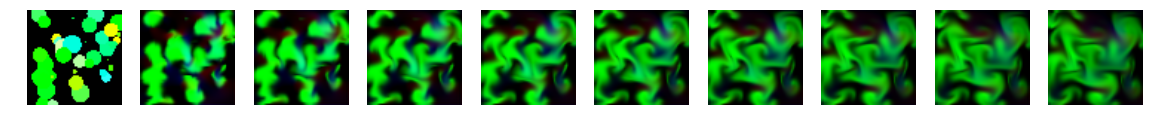

In [15]:
seq = generate_sequence((64,64),10,10)
print(seq.shape)
plot_images(seq)

In [16]:
def generate_data(imgsize, batchsize, seqlen, stride):
    batch = []
    for i in range(batchsize):
        seq = generate_sequence(imgsize, seqlen, stride)
        batch.append(seq)
    data = np.stack(batch).transpose((1,0,2,3,4))
    return data

(10, 4, 3, 64, 64)


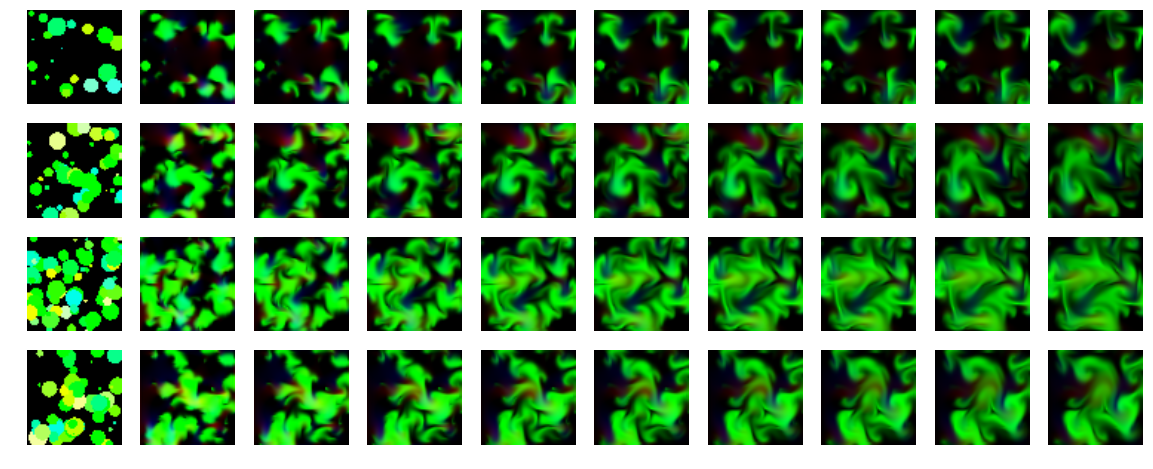

In [17]:
data = generate_data((64,64),4,10,10)
print(data.shape)
plot_images(data)

In [18]:
def augment_sequence(seq, size):
    # random crop
    vx, vy = seq.shape[-1]-size[0], seq.shape[-2]-size[1]
    x, y = np.random.randint(0, vx), np.random.randint(0, vy)
    aug_seq = seq[:,:,y:y+size[1],x:x+size[0]]
    # random flip (need to flip speed dir)
    #fx, fy = [np.random.choice([-1, 1]) for _ in range(2)]
    #data = data[:][:][::fy][::fx]
    return aug_seq

(10, 3, 32, 32)


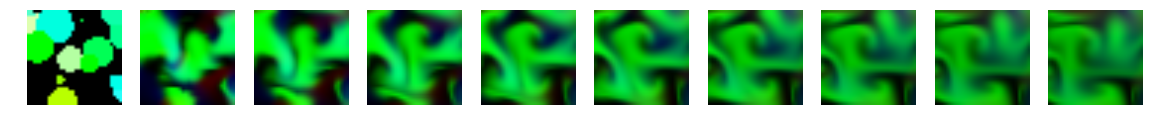

In [19]:
aug_seq = augment_sequence(seq, (32,32))
print(aug_seq.shape)
plot_images(aug_seq)

In [20]:
def augment_data(seq, imgsize, batchsize):
    batch = []
    for i in range(batchsize):
        aug_seq = augment_sequence(seq, imgsize)
        batch.append(aug_seq)
        #print(aug_seq.shape)
    data = np.stack(batch).transpose((1,0,2,3,4))
    return data

(10, 4, 3, 32, 32)


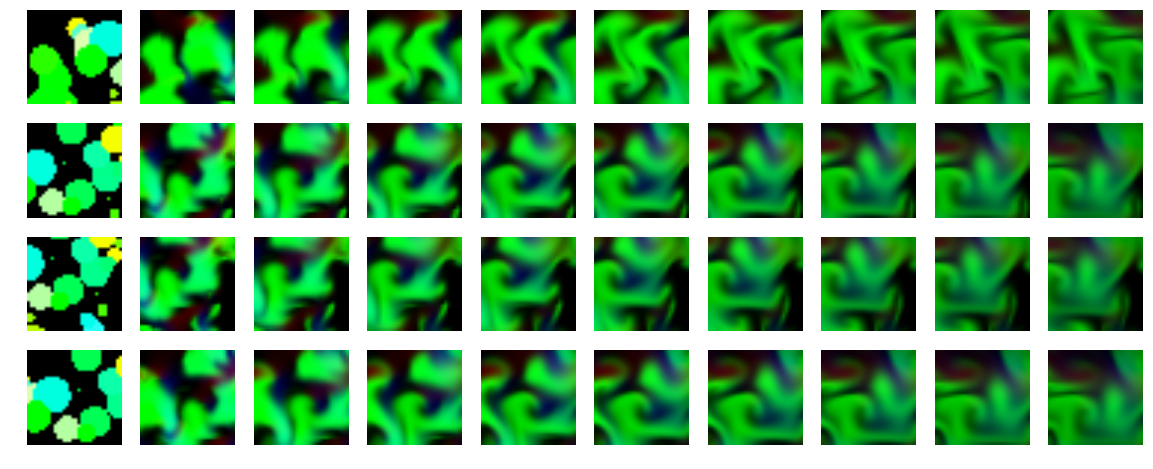

In [21]:
aug_data = augment_data(seq, (32,32), 4)
print(aug_data.shape)
plot_images(aug_data)

In [22]:
torch.cuda.is_available()

True

In [23]:
class UNetLike(nn.Module):
    def __init__(self, down, middle, up, ksize=3):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        levels = []
        for level in down:
            layers = []
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.append(nn.MaxPool2d(2, stride=2))
            levels.append(nn.ModuleList(layers))
        self.down = nn.ModuleList(levels)
        
        layers = []
        for conv_in, conv_out in zip(middle[:-1], middle[1:]):
            layers.extend([
                nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                nn.ReLU(),
            ])
        self.middle = nn.ModuleList(layers)
        last_size = middle[-1]
        
        levels = []
        for level in up:
            layers = []
            layers.append(nn.ConvTranspose2d(last_size, level[0], kernel_size=2, stride=2))
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.ConvTranspose2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.pop()
            levels.append(nn.ModuleList(layers))
            last_size = level[-1]
        self.up = nn.ModuleList(levels)
        
        layers = []
        for down_level, up_level in zip(down, reversed(up)):
            layers.append(nn.Conv2d(down_level[-1], up_level[0], kernel_size=1, padding=0))
        self.short = nn.ModuleList(layers)
    
    def forward(self, x):
        indices = []
        shortcuts = []
        for d, s in zip(self.down, self.short):
            for i, l in enumerate(d):
                #print("down %s: %s" % (i, x.shape))
                x = l(x)
                if i == len(d) - 2:
                    shortcuts.append(s(x))
            
        for i, l in enumerate(self.middle):
            #print("middle %s: %s" % (i, x.shape))
            x = l(x)
        
        for u, z in zip(self.up, reversed(shortcuts)):
            for i, l in enumerate(u):
                #print("%s: %s" % (i, x.shape))
                if i == 1:
                    #print("z: %s" % (z.shape,))
                    x = x + z
                x = l(x)
        return x

In [24]:
def train_model(model, loss_fn, optimizer, data, lap, jumps=1, test=False):
    if test:
        model.eval()
    else:
        model.train()
        
    avg_loss = 0.0
    steps = 0
    for i in range(len(data)):
        x_var = Variable(Tensor(data[i]).cuda(), volatile=test)

        if not test:
            optimizer.zero_grad()
        
        for j in range(1,jumps+1):
            try:
                y_var = Variable(Tensor(data[i + lap*j]).cuda(), volatile=test)
            except IndexError:
                break
                
            y_pred = model(x_var)
            
            loss = loss_fn(y_pred, y_var)
            avg_loss += loss.data[0]
            steps += 1
            
            if not test:
                loss.backward(retain_graph=True)
            
            x_var = y_pred

        if not test:
            optimizer.step()
        
    return avg_loss/steps

In [25]:
def apply_model(model, seq):
    model.eval()
    result = []
    for x in seq:
        x_var = Variable(Tensor(x.reshape(1, *x.shape)).cuda(), volatile=True)
        y_pred = model(x_var)
        result.append(y_pred.data.cpu().numpy())
    result = np.stack(result)
    return result

In [26]:
def autogen_model(model, image, loops):
    model.eval()
    result = []
    x = image.reshape(1, *image.shape)
    result.append(x)
    x_var = Variable(Tensor(x).cuda(), volatile=True)
    for j in range(loops):
        torch.clamp(x_var, -1, 1)
        x_var = model(x_var)
        result.append(x_var.data.cpu().numpy())
    result = np.stack(result)
    return result

In [27]:
def train(
    model, loss_fn, optimizer,
    lap, stride, 
    batch_size, loops, jumps, augment,
    scene_size, model_size, seqlen, test_seqlen,
    epoch=0, losses=([],[]), plot=True,
):
    stop_on_signal()
    #last = time.time()
    while not signal_done:
        #now = time.time()
        #if now - last >= 10.0:
            #last = now

        print("generating data ...")
        if augment:
            seq = generate_sequence(scene_size, seqlen, stride=stride)
        else:
            data = generate_data(model_size, batch_size, seqlen, stride=stride)

        print("training model ...")
        if augment:
            loss = 0.0
            for l in range(loops):
                data = augment_data(seq, model_size, batch_size)
                loss += train_model(model, loss_fn, optimizer, data, lap=lap, jumps=jumps)
            loss /= loops
        else:
            loss = train_model(model, loss_fn, optimizer, data, lap=lap, jumps=jumps)
        losses[0].append(loss)

        print("testing model ...")
        test_seq = generate_sequence(model_size, test_seqlen + lap, stride=stride)
        test_data = test_seq.reshape(1, *test_seq.shape).transpose(1,0,2,3,4)

        test_loss = train_model(model, loss_fn, None, test_data, lap=lap, jumps=jumps, test=True)
        test_out = apply_model(model, test_seq[::lap])
        losses[1].append(test_loss)

        gen_out = autogen_model(model, test_seq[0], loops=test_seqlen//lap)

        clear_output(wait=True)
        print("epoch: %s, train_loss: %s, test_loss: %s" % (epoch, loss, test_loss))
        if plot:
            plot_images(data[::lap,0])
            
            plt.plot(losses[0], label="train loss")
            plt.plot(losses[1], label="test loss")
            plt.legend()
            plt.show()

            plot_images(test_seq[::lap])
            plot_images(test_out)
            plot_images(gen_out)

        epoch += 1
    return epoch

In [28]:
model = UNetLike(
    down=(
        (3, 16, 16),
        (16, 32, 32),
        (32, 64, 64),
    ),
    middle=(64, 128, 128),
    up=(
        (64, 64, 64),
        (32, 32, 32),
        (16, 16, 16, 3),
    ),
).cuda()

In [30]:
loss_fn = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [31]:
lap = 10
stride = 1
epoch = 0
losses = ([],[])

epoch: 45, train_loss: 0.0002510449153815876, test_loss: 0.00018865371486754157


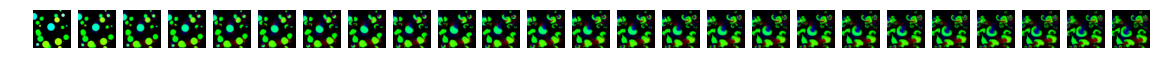

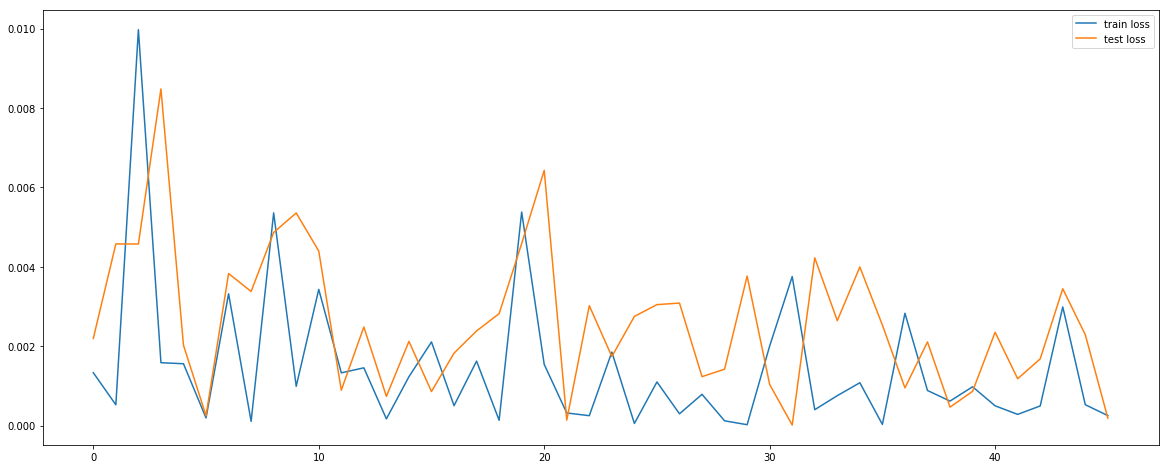

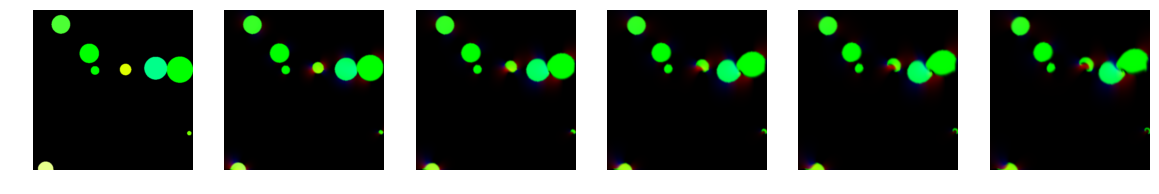

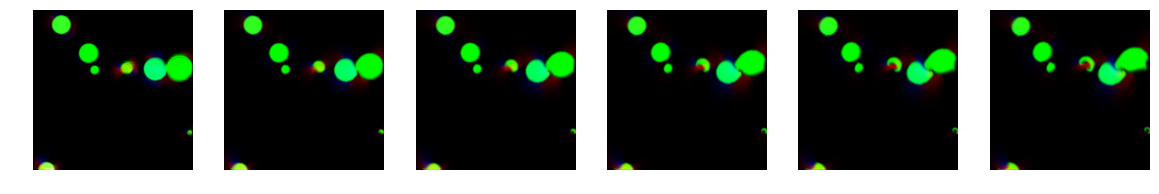

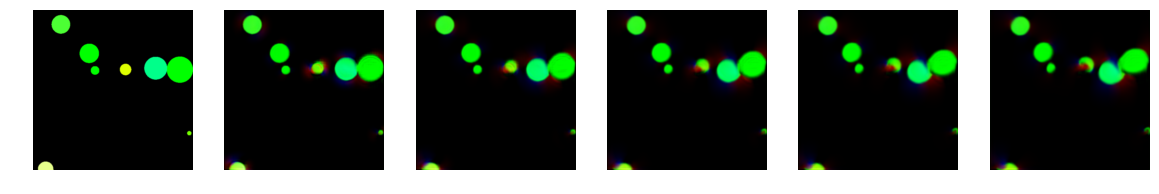

In [44]:
epoch = train(
    model, loss_fn, optimizer,
    lap=lap, stride=stride,
    
    batch_size=1,
    loops=1,
    jumps=8,
    augment=False,
    
    scene_size=(1024,1024),
    model_size=(512,512),
    seqlen=250,
    test_seqlen=50,
    
    epoch=epoch,
    losses=losses,
    plot=True
)

In [53]:
torch.save(model.state_dict(), "model_2.1.1.data")

In [29]:
model.load_state_dict(torch.load("model_2.1.1.data"))

In [37]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [38]:
def make_video(seq):
    params = {
        "-vcodec": "libx264",
        "-pix_fmt": "yuv420p",
        "-profile:v": "baseline",
        "-level": "3"
    }
    video = FFmpegWriter("tmp.mp4", outputdict=params)
    for img in seq:
        cimg = convert_image(img)
        video.writeFrame(cimg)
    video.close()

In [39]:
def display_video():
    with open("tmp.mp4", "rb") as f:
        vdata = f.read()
    vbase64 = base64.b64encode(vdata).decode("ascii")
    display(HTML('<video controls width=800 src="data:video/mp4;base64,%s" type="video/mp4" >' % vbase64))

In [54]:
_seqlen = 10*24
ref_seq = generate_sequence((960,1080), _seqlen, stride=stride*lap)

In [55]:
gen_seq = autogen_model(model, ref_seq[0], loops=_seqlen)
gen_seq = gen_seq.reshape(gen_seq.shape[0],*gen_seq.shape[2:])

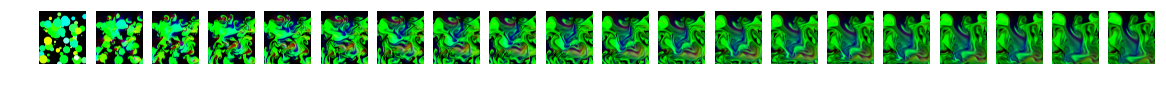

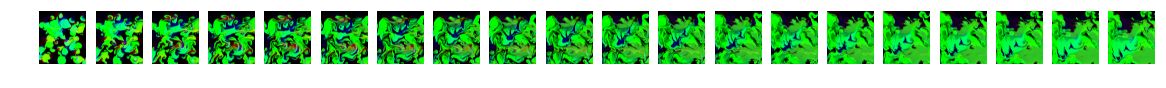

In [56]:
plot_images(ref_seq[::12])
plot_images(gen_seq[::12][1:])

In [ ]:
print(ref_seq.shape)
print(gen_seq.shape)
cat_seq = np.concatenate((ref_seq, gen_seq[:-1]), axis=-1)
make_video(cat_seq)
display_video()

In [101]:
for i, (ref_img, gen_img) in enumerate(zip(ref_seq, gen_seq)):
    ref_img = convert_image(ref_img)
    gen_img = convert_image(gen_img)
    img = np.concatenate((ref_img, gen_img), axis=1)
    pil_img = Image.fromarray(img)
    pil_img.save("images/%02d.png" % (i+1))

In [ ]:
aug_data = augment_data(seq, (256,256), 16)
print(aug_data.shape)
for img in aug_data[-1]:
    display(Image.fromarray(convert_image(img)))